The main steps in this subsection are as follows:

1. **Data cleansing and calculation of retention rates:**
   - Read the user's last two weeks of game data from a JSON file.
   - Cleans the data, removing no game records and irrelevant columns.
   - Calculate retention rate: divide the last two weeks of game time by the total game time and convert to a percentage. Since the total game time may be zero, this case needs to be handled to avoid division by zero errors.
   - Display the results of the retention rate, selectively displaying the game ID, name, last two weeks game time, total game time and retention rate.

2. **Save the result to JSON file:**
   - Select the game ID, name and retention rate and save the result to a new JSON file.

3. **Visualize the retention rate and analyze the results:**
   - Read data from the previously saved JSON file.
   - Collect the data into a Pandas DataFrame for visualization.
   - Create a graphical canvas with two subplots: a histogram of the retention rate distribution and a box-and-line plot of the retention rate.
   - Display the histogram and box-and-line plot to visualize the distribution and statistics of the retention rate.

In [9]:
'''2.2.1 Clean and calculate retention rate for users' recent two weeks' game data'''
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, when, size
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Retention Rate Analysis") \
    .getOrCreate()

# Read the data
df = spark.read.json("/Users/a1234/Desktop/workspace/Steam_Recommendation_System_777_tp/Data/user_recently_played_games.json")

# Clean the data: remove users with no game records and drop irrelevant columns
cleaned_df = df.filter((col("total_count") > 0) & (size(col("games")) > 0))
exploded_games = cleaned_df.withColumn("game", explode(col("games"))).select("steamid", "game.*")
final_df = exploded_games.drop("img_icon_url")

# Calculate retention rate
final_df = final_df.withColumn("retention_rate", 
                               (col("playtime_2weeks") / col("playtime_forever")) * 100)

# Since playtime_forever could be 0, we need to handle this case to avoid division by zero
final_df = final_df.withColumn("retention_rate", 
                               when(col("playtime_forever") == 0, 0).otherwise(col("retention_rate")))

# Display the retention rate results, adjust the number of rows to display as needed
final_df.select("appid", "name", "playtime_2weeks", "playtime_forever", "retention_rate").show()

# Save the game ID, name, and retention rate to a new JSON file
(final_df.select("appid", "name", "retention_rate")
        .write
        .format("json")
        .mode("overwrite")
        .save("/Users/a1234/Desktop/workspace/Steam_Recommendation_System_777_tp/Processed_Data/retention_rates.json"))

# Stop the Spark session
spark.stop()


+-------+--------------------+---------------+----------------+-------------------+
|  appid|                name|playtime_2weeks|playtime_forever|     retention_rate|
+-------+--------------------+---------------+----------------+-------------------+
|1245620|          ELDEN RING|            162|           28847| 0.5615835268832114|
|1594320| Captain of Industry|             58|            5022| 1.1549183592194345|
|2141910|Magic: The Gather...|             51|            3143| 1.6226535157492843|
|1158160|        Coral Island|             76|              76|              100.0|
| 990080|     Hogwarts Legacy|              4|            3001|0.13328890369876709|
|1013140|Outcast - A New B...|              3|            1393|0.21536252692031585|
|1151640|Horizon Zero Dawn...|            758|            2826| 26.822363765038926|
| 990080|     Hogwarts Legacy|            227|           12704|   1.78683879093199|
|2471100|  Unnamed Space Idle|          13447|          122714| 10.957999902

24/04/21 03:13:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


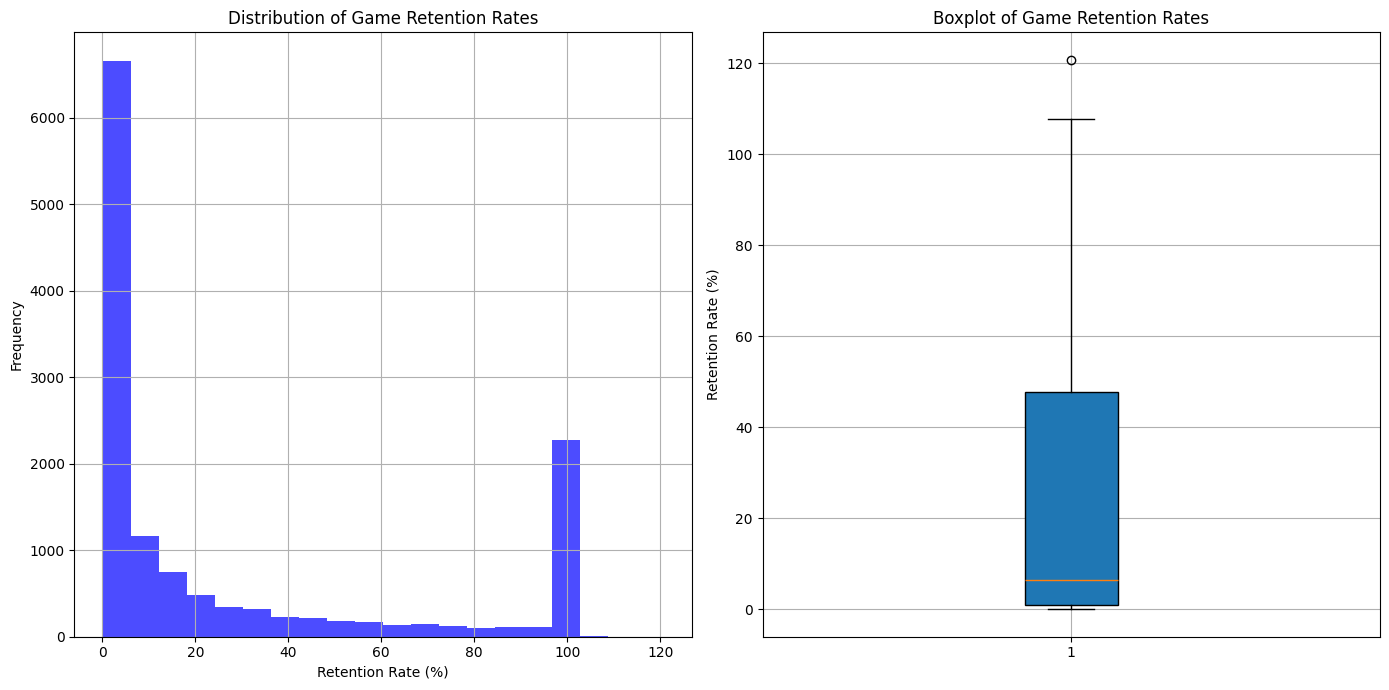

In [11]:
'''Visualize retention rate and analyze the results'''
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Visualize Retention Data from JSON with Histogram and Boxplot") \
    .getOrCreate()

# Read the JSON file
df = spark.read.json("/Users/a1234/Desktop/workspace/Steam_Recommendation_System_777_tp/Processed_Data/retention_rates.json")

# Collect data into a Pandas DataFrame for visualization
pandas_df = df.toPandas()

# Create a figure canvas, set the size
plt.figure(figsize=(14, 7))

# First subplot: Histogram
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.hist(pandas_df['retention_rate'], bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Game Retention Rates')
plt.xlabel('Retention Rate (%)')
plt.ylabel('Frequency')
plt.grid(True)

# Second subplot: Boxplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.boxplot(pandas_df['retention_rate'], vert=True, patch_artist=True)
plt.title('Boxplot of Game Retention Rates')
plt.ylabel('Retention Rate (%)')
plt.grid(True)

# Show the plot
plt.tight_layout()  # Adjust subplot spacing
plt.show()

# Stop the Spark session
spark.stop()


#### Retention rate distribution analysis
From the graph we can see the data characteristics of the game retention rate:

1. **Histogram**:
   - Most of the games' retention rates are clustered around 0%, which indicates that a large number of games have hardly been played in the last two weeks.
   - There are also some games with very high retention rates, even up to 100%, which means that players of these games have been relatively active in the past two weeks.
   - The histogram shows a long-tailed distribution with a small number of games maintaining relatively high retention rates.

2. **Box line diagram**:
   - The box-and-line plot shows a low median retention rate, which is consistent with the concentrated trend observed in the histogram.
   - The box shows that most games have retention rates very close to 0%, while the first and third quartiles are very close to each other, implying that the middle 50% of games have little change in retention rates.
   - There are some outliers, which are much higher than the third quartile, indicating that some games have unusually high retention rates.

Some of the unusually high retention rates may be due to users only starting to play the game within the last two weeks, or the game being recently released. In the subsequent analysis, we need to pay attention to whether too high retention rate affects the results of the recommender system.